In [2]:
import numpy as np
import matplotlib.pyplot as plt

Ok, so none of the simulation attempts have worked so far. I think what I'm gunna try to do is just implement the model that they said is the one that best reflects the biology, and not try to do all of it. I.e., a ring attractor model with "narrow local excitiation and flat long-range inhibition" (Kim et al. 4)

NB! in the paper they actually looked at only the Ring Attractor Global Model w/ Cosine connectivity, and the Ring Attractor Local Model (uniform inhibition with local excitation) (Kim et al. 1)

Both models were able to generate jump and flow responses depending on the stimulus shift (ibid.). But the jump-flow balance was different. Specifically, the local model's dynamics were more consistant with experimental results (Kim et al. 2).
1. Global model requires much stronger visual input to get bump jumps (ibid)
2. Global model requires much wider range of visual input strength to "explain jumps at multiple distances" (ibid)
3. Using empirical paramters, the observed jump-flow ratio could be reproduced with the local model, but not the global model. (ibid)
4. Laser power required to get a jump was "not [really] different between shift distances, favoring local model" (ibid)
5. Optogenetic input strength needed to "induce a jump was smaller than the global model's prediciton but matched the local model's prediciton" (ibid)
6. Intermediate models that had right kind of behavior "in response to a weak 22.5 degree wide input had a narrow connectivity profile" (Kim et al. 3), aligning with the local model. 


So, let's implement the local model

NB! Threshold linear -> max(0, input + 1)

NB! "branch of cosine" -> only a portion of the cosine curve used to describe the bump; activity out of this range set to 0. localized bump, where width is determined by periodicity of cosine and parameters of local connectivity. 

Dynamics of local model:
$$
\tau \frac{\partial f_n(t)}{\partial t} = -f_n(t) + \left[ \alpha f_n(t) + D \big( f_{n+1}(t) + f_{n-1}(t) - 2f_n(t) \big) - \beta \sum_{m=0}^{N-1} f_m(t) + I_n(t) \right]_+
$$

where $a$ is local recurrent excitation strength, $\Beta$ is global inhibition strength, $D$ is the diffusion coefficient (local coupling between neighbours), $I_n(t)$ is external input to neuron n and $[\cdot]_+$ is the 'threshold linear function'

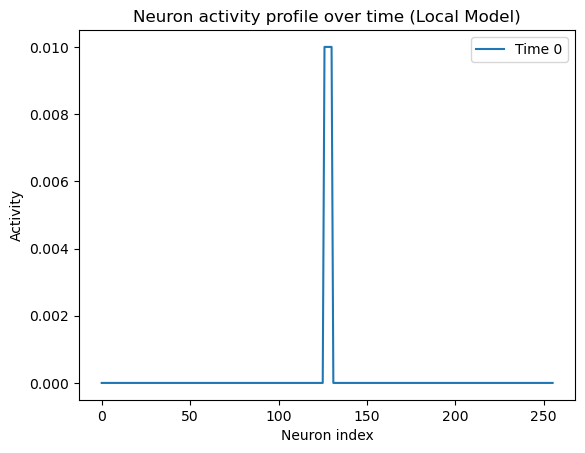

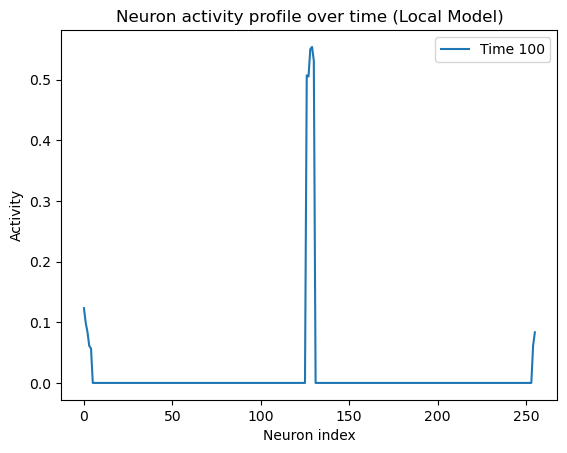

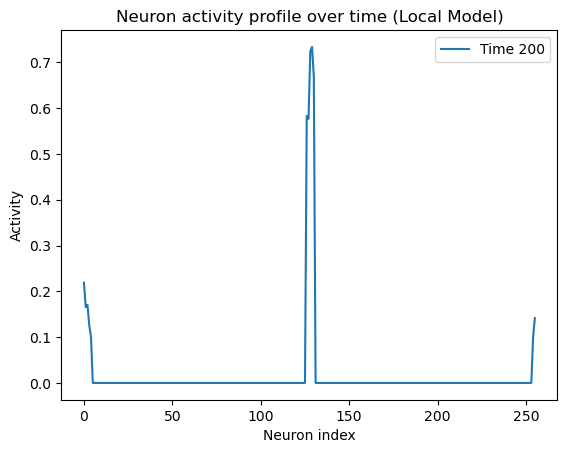

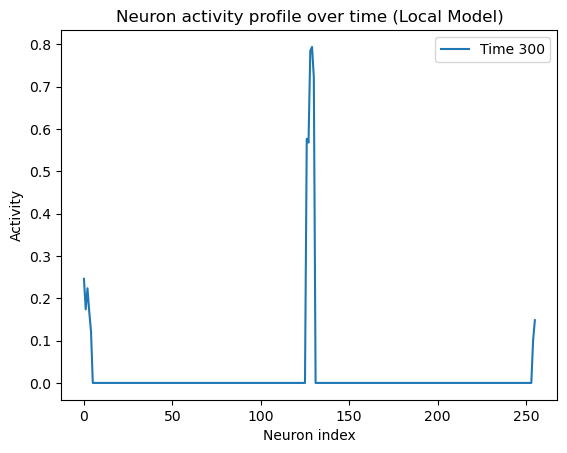

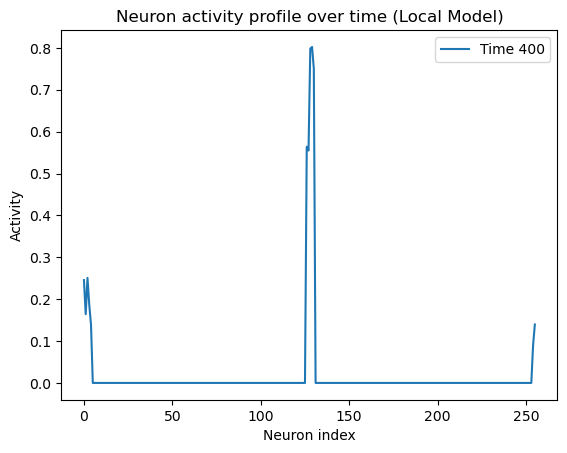

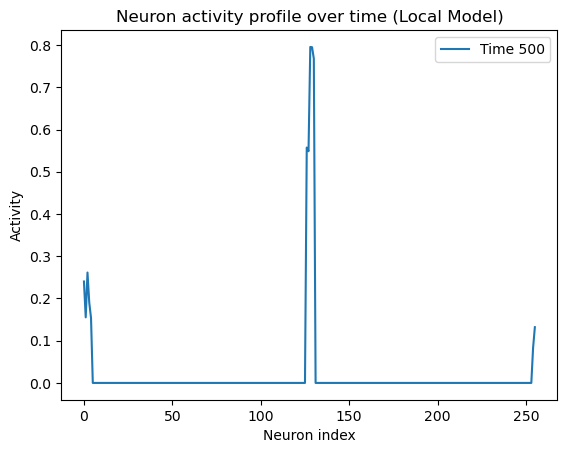

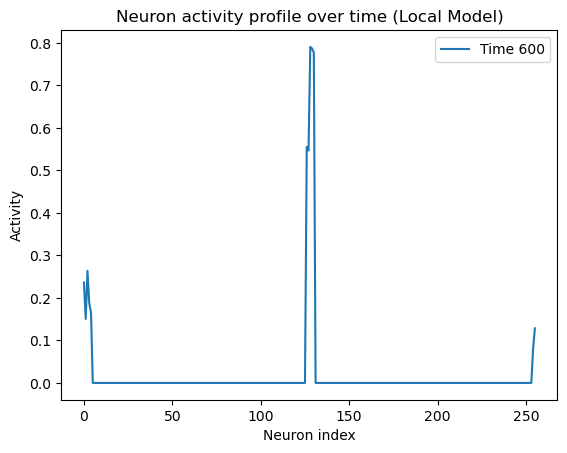

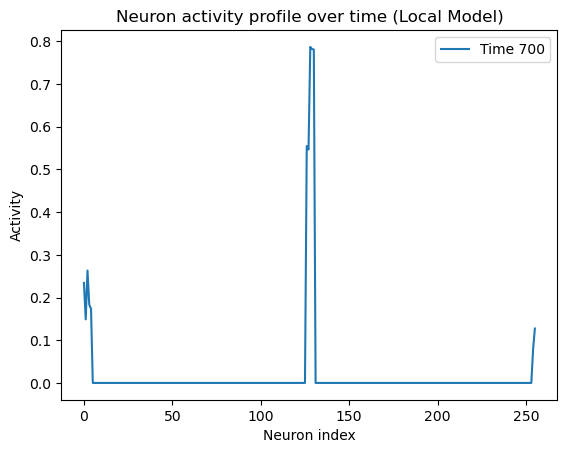

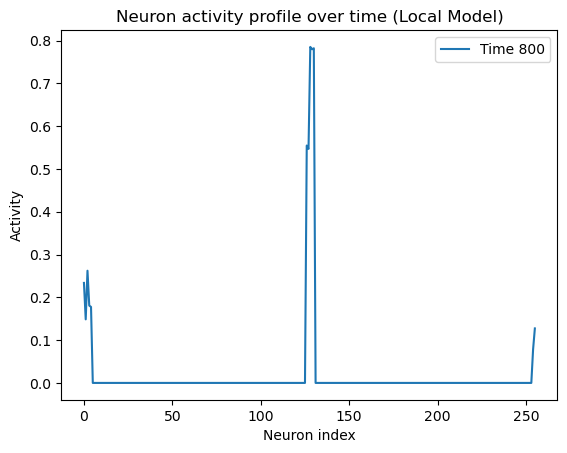

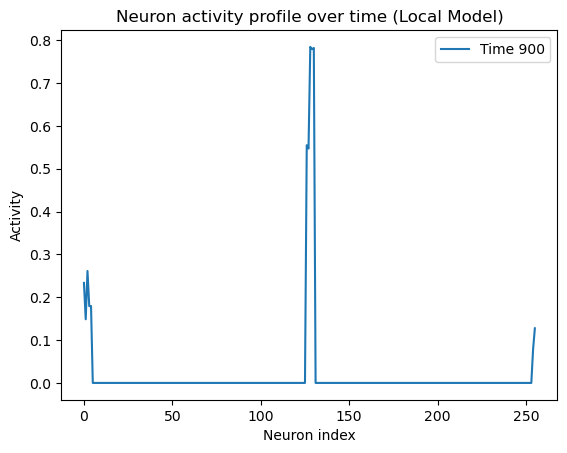

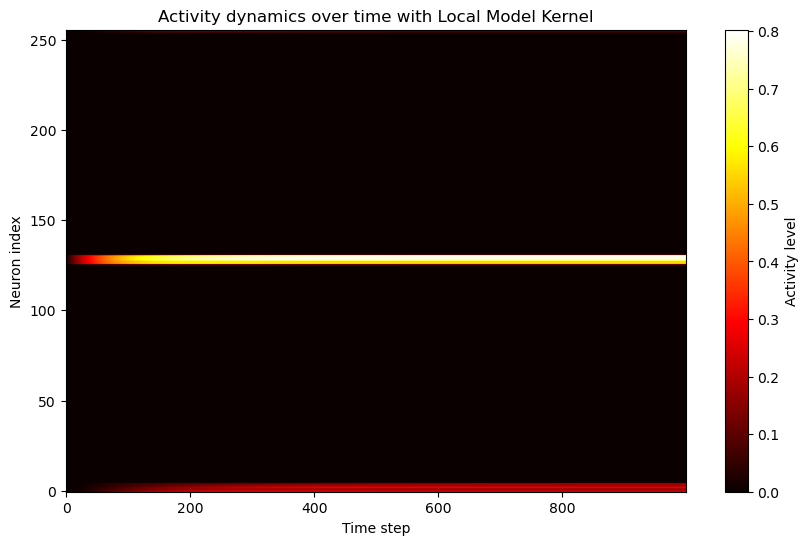

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#TODO: add polar figure type
# Parameters
N = 256              # Number of neurons in the ring
tau = 1.0            # Time constant
alpha = 0.8          # Strength of local excitation (nearest neighbors)
beta = 0.1           # Strength of global inhibition
dt = 0.01            # Time step
T = 1000             # Total number of simulation steps
I = np.zeros(N)
I[N // 2 - 2:N // 2 + 3] = 1      # External input in the middle (copied from Enrique)

# Initialize activity
f = np.random.rand(N) * 1.0e-10  # Small random activity for initialization

# Define the connectivity kernel
kernel = np.zeros(N)
kernel[1] = kernel[-1] = alpha  # Local excitation to nearest neighbors
kernel += -beta                 # Global inhibition (uniform for all neurons)

# Simulation storage
activity_over_time = []

# Simulation loop
for t in range(T):
    # Compute net input via circular convolution
    net_input = np.convolve(f, kernel, mode='same')  # Periodic convolution

    # Update neuron activity using the kernel
    new_f = f + (dt / tau) * (-f + np.maximum(0, net_input + I))

    # Update activity
    f = new_f
    activity_over_time.append(f.copy())

    # Optional: Plot activity every 100 steps
    if t % 100 == 0:
        plt.plot(f, label=f'Time {t}')
        plt.title("Neuron activity profile over time (Local Model)")
        plt.xlabel("Neuron index")
        plt.ylabel("Activity")
        plt.legend()
        plt.show()

# Convert activity over time to a heatmap
activity_over_time = np.array(activity_over_time)

# Plot the heatmap of activity dynamics
plt.figure(figsize=(10, 6))
plt.imshow(activity_over_time.T, aspect='auto', cmap='hot', origin='lower')
plt.colorbar(label="Activity level")
plt.xlabel("Time step")
plt.ylabel("Neuron index")
plt.title("Activity dynamics over time with Local Model Kernel")
plt.show()

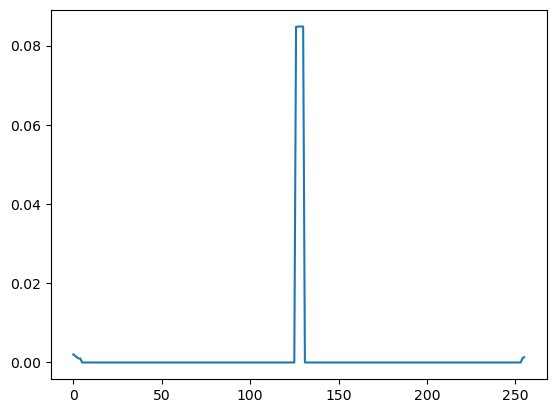

In [41]:
plt.plot(activity_over_time[8, :])

Ok, so we try to reproduce figure 4.D., i.e., the state-space graphs for the two models, because that shows how one is a better representation of the thing. 

I think the first step is really to do it for the local model, and then reimplement it for the global model. Doing them both at the same time will be a real pain. 

## Phase-Diagram

What do we need?

y-axis = Input Strength (normalized bump amplitude (not entirely sure what this is))

x-axis = Input Width (distance between inflection points of input profile modeled with von Mises function)

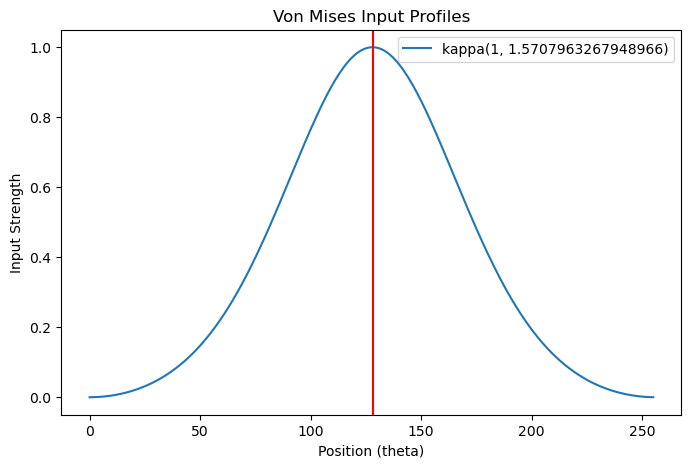

In [431]:
# Von Mises:
# Parameters
N = 256          # Number of neurons (discrete positions on the ring)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Circular positions
A = 1.0           # Amplitude of the input
kappa1= 1
kappa2= np.pi/2 # Different concentration parameters
mu = np.pi# Center of the input profile (radians)
mu2 = 2 * np.pi/4

def von_mises(A, kappa, theta, mu): #Their implementation of the function
    if kappa > 5:
        return A * np.exp(kappa * (np.cos(theta - mu) - 1))
    else:
        return A * (np.exp(kappa * (np.cos(theta - mu) + 1)) - 1) / (np.exp(2 * kappa) - 1)

# def von_mises(A, kappa, theta, mu): #Their implementation of the function
#     return A * np.exp(kappa * (np.cos(theta - mu) - 1))
    
# Generate and plot von Mises profiles for different kappa


vm1 = von_mises(A, kappa1, theta, mu)
# vm2 = von_mises(A, kappa2, theta, mu2)
vm = vm1

plt.figure(figsize=(8, 5))
plt.plot(vm, label=f'kappa{kappa1, kappa2}')
# plt.plot(vm2, linestyle='--')
# plt.plot(vm1, linestyle='--')
plt.title('Von Mises Input Profiles')
plt.axvline(x=256/2, color='red')
plt.xlabel('Position (theta)')
plt.ylabel('Input Strength')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Convert von Mises concentration (kappa) to approximate input width in radians
def input_width_from_kappa(kappa):
    return 2 * np.arccos(1 - np.log(2) / kappa)

# Compute input widths for a range of kappa values
kappa_values = np.linspace(0.5, 20, 100)
input_widths = input_width_from_kappa(kappa_values)

# Plot the relationship between kappa and input width
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(kappa_values, input_widths / np.pi, label='Input Width (scaled by π)')
plt.axhline(y=0.25, color='r', linestyle='--', label='π/4')
plt.axhline(y=0.5, color='g', linestyle='--', label='π/2')
plt.axhline(y=0.75, color='b', linestyle='--', label='3π/4')
plt.title('Input Width vs Kappa')
plt.xlabel('Kappa (Concentration Parameter)')
plt.ylabel('Input Width (in units of π)')
plt.legend()
plt.show()

Ok, so we need an initial bump, and then to add the next bump. 

we do it by width and then distance. Specifically, we need the centering neuron $\mu$, given in terms of $\pi$.

then we need the width of the input, i.e., kappa $k$. NB! this parameter is interesting. acutally, to get kappa we need to do some arithmetic. Specifically, the width of the input bump given in the plot is in radians. This is related to $k$ in that Width = $2 \arccos(1- \frac{1}{k})$. So, 
$$k = \frac{1}{1-\cos (\frac{\text{Width}}{2})}$$

And then we can also modulate the amplitude, $A$

And then there is the shift distance, i.e., the difference between the original theta and the input theta, i.e., $\theta_{input}$ -  $\theta_{init}$

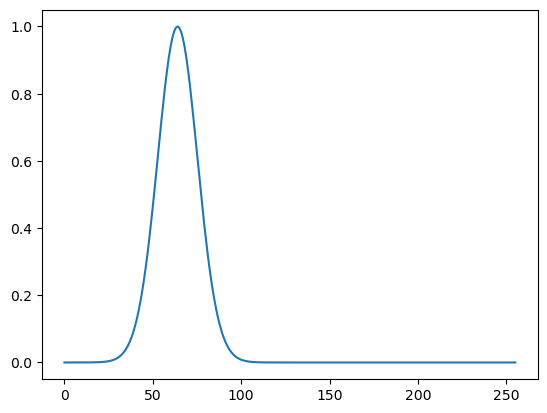

In [435]:
N = 256 #number of neurons
A = 1.0 #amplitude of the bump
kappas = [1/(1-np.cos(k/2)) for k in np.linspace(np.pi/4, (3*np.pi)/4)]
kappa_init = kappas[0] #width of initial bump
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
mu_init = np.pi/2

vm = von_mises(A, kappa_init, theta, mu_init)
plt.plot(vm)

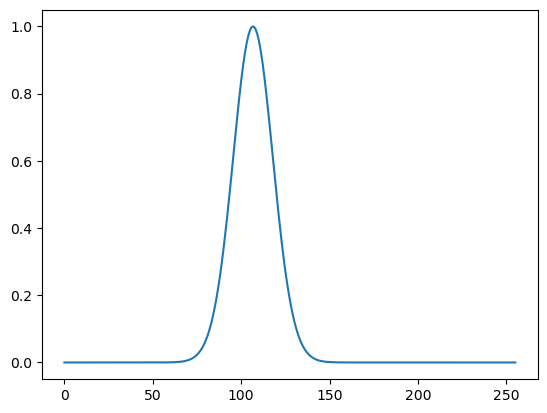

In [434]:
#additional bump array for a 60 degree shift
amplitudes = np.arange(1, 2, 0.1)
mu_60 = mu_init + np.pi/3
mu_90 = mu_init + np.pi/2
mu_120 = mu_init + 2*np.pi/3
mu_150 = mu_init + 5*np.pi/6

for amplitude in amplitudes:
    for kappa in kappas:
        vm = von_mises(amplitude, kappa, theta, mu_60)
        plt.plot(vm)
        break
    break



Ok, let's see if we can do some simulating then. Let's start with a 60 degree shift

In [ ]:
class RingAttractor:
    def __init__(self, num_neurons, tau=1, D=0.1, dt=0.1, T=1000):
        self.num_neurons = num_neurons
        self.tau = tau
        self.D = D
        self.dt = dt
        self.T = T

        #initialize the neurons
        self.theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
        #connectivity kernel
        self.kernel = self._connectivity_kernel()
        self.f = np.zeros(N) #initial activity profile
        self.mu_init = np.pi/2 #initial bump center, we'll say it's always at the front of the fly


    def _connectivity_kernel(self, model_type:str):
        """This generates the connectivity kernel for each model type"""
        if model_type == "local":
            kernel = np.zeros(self.N) #same size as num_neurons
            for neuron_index in range(self.N):
                d = min(neuron_index, self.N - neuron_index)
                if d == 1:
                    kernel[neuron_index] = self.D
            return kernel

    def von_mises(amplitude, kappa, theta, mu): #Their implementation of the function
        if kappa > 5:
            return amplitude * np.exp(kappa * (np.cos(theta - mu) - 1))
        else:
            return amplitude * (np.exp(kappa * (np.cos(theta - mu) + 1)) - 1) / (np.exp(2 * kappa) - 1)

    def initial_bump(self, amplitude, kappa, center=None):
        """Initializes the activity profile via the von Mises function"""
        if center is None:
            center = self.mu_init
        self.f = von_mises(amplitude, kappa, self.theta, center)
